In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [2]:
import os
import cv2
import numpy as np

data_dir = "UTKFace"
image_size = 64

images = []
ages = []

for img_name in os.listdir(data_dir):
    try:
        age = int(img_name.split('_')[0])
        if age > 100:
            continue  # Skip outliers
        path = os.path.join(data_dir, img_name)
        img = cv2.imread(path)

        # ✅ Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img = cv2.resize(img, (image_size, image_size))
        images.append(img)
        ages.append(age)
    except Exception as e:
        print(f"Skipping image {img_name}: {e}")


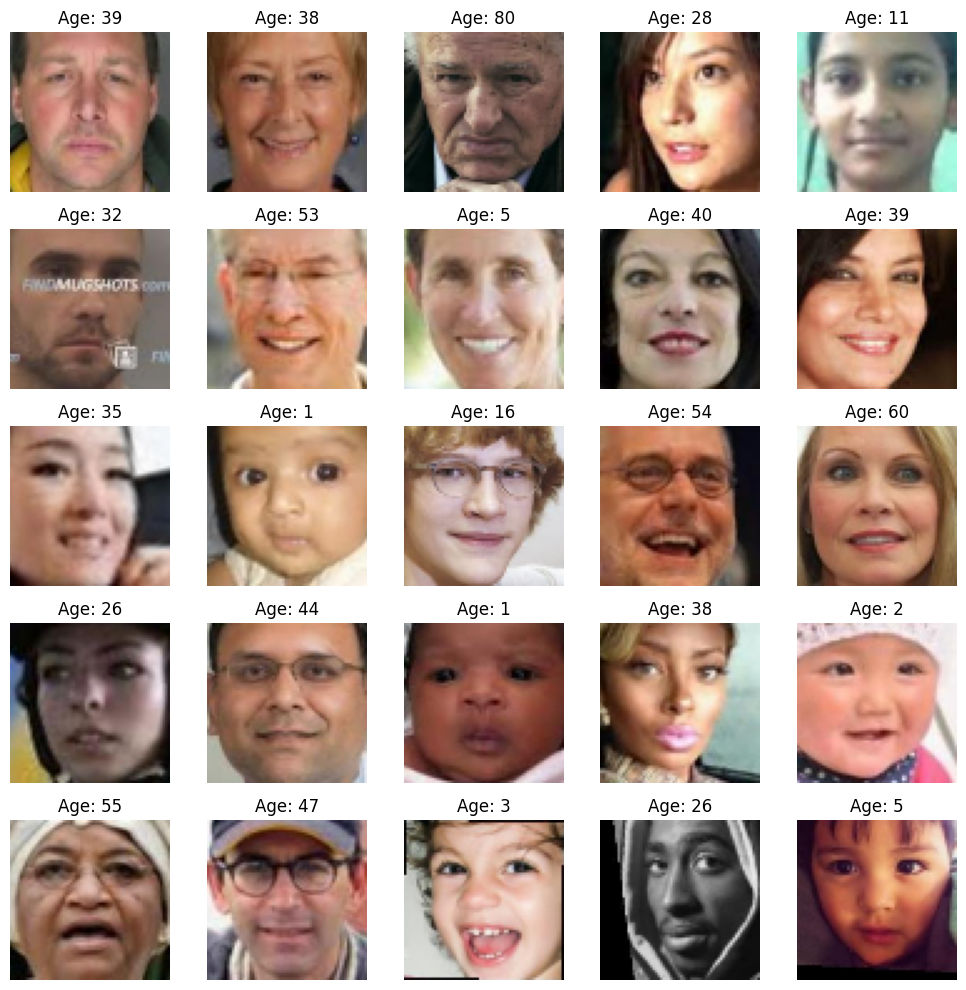

In [3]:
# Show 25 random images with age
plt.figure(figsize=(10, 10))

for i in range(25):
    idx = random.randint(0, len(images) - 1)
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[idx])
    plt.title(f"Age: {ages[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


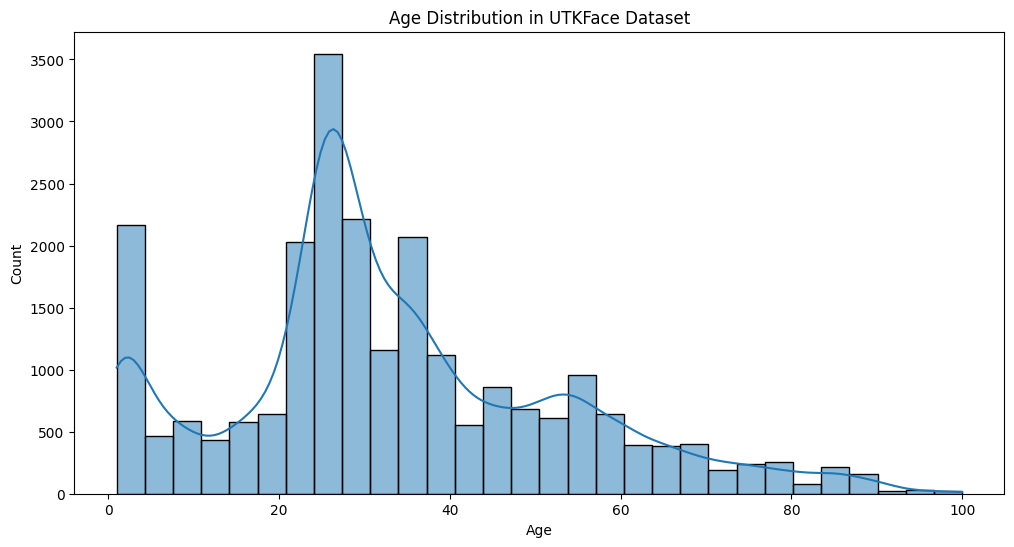

In [4]:
import seaborn as sns
import pandas as pd

age_df = pd.DataFrame({"Age": ages})
plt.figure(figsize=(12, 6))
sns.histplot(age_df["Age"], bins=30, kde=True)
plt.title("Age Distribution in UTKFace Dataset")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


In [5]:
print("Total images:", len(ages))
print("Youngest age:", np.min(ages))
print("Oldest age:", np.max(ages))
print("Average age:", np.mean(ages))



Total images: 23687
Youngest age: 1
Oldest age: 100
Average age: 33.23590999282307


In [6]:
from collections import Counter

age_counts = Counter(ages)
for age, count in sorted(age_counts.items())[:20]:  # first 20 ages
    print(f"Age {age}: {count} images")


Age 1: 1123 images
Age 2: 482 images
Age 3: 289 images
Age 4: 273 images
Age 5: 196 images
Age 6: 131 images
Age 7: 139 images
Age 8: 263 images
Age 9: 166 images
Age 10: 156 images
Age 11: 65 images
Age 12: 130 images
Age 13: 81 images
Age 14: 157 images
Age 15: 177 images
Age 16: 247 images
Age 17: 158 images
Age 18: 262 images
Age 19: 98 images
Age 20: 284 images


In [7]:
def age_to_group(age):
    if age <= 12:
        return 0  # Child
    elif age <= 18:
        return 1  # Teen
    elif age <= 35:
        return 2  # Young Adult
    elif age <= 60:
        return 3  # Adult
    else:
        return 4  # Senior

age_groups = [age_to_group(a) for a in ages]

# Convert to one-hot encoded labels
y_cat = to_categorical(age_groups, num_classes=5)

# Convert and normalize image data
X = np.array(images) / 255.0
y = np.array(y_cat)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()

# Conv Block 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Block 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Block 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Flatten and Dense layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Output layer: 5 classes
model.add(Dense(5, activation='softmax'))


c:\Users\Viraj Sawant\OneDrive\Desktop\Age And Emotion Detector\Age_D\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,275,333 (4.87 MB)

 Trainable params: 1,274,885 (4.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
history = model.fit(
    X_train, y_train,
    epochs=30,             # more training time
    batch_size=32,         # smaller batches help training
    validation_split=0.2
)


Epoch 1/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 116s 231ms/step - accuracy: 0.5039 - loss: 1.7714 - val_accuracy: 0.5467 - val_loss: 1.0558
Epoch 2/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 98s 207ms/step - accuracy: 0.6450 - loss: 0.8980 - val_accuracy: 0.5609 - val_loss: 1.1919
Epoch 3/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 94s 197ms/step - accuracy: 0.6752 - loss: 0.8058 - val_accuracy: 0.6172 - val_loss: 0.9633
Epoch 4/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 62s 130ms/step - accuracy: 0.6815 - loss: 0.7744 - val_accuracy: 0.6314 - val_loss: 0.8398
Epoch 5/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 62s 131ms/step - accuracy: 0.7093 - loss: 0.7254 - val_accuracy: 0.5997 - val_loss: 1.0258
Epoch 6/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 67s 141ms/step - accuracy: 0.7150 - loss: 0.7013 - val_accuracy: 0.6306 - val_loss: 1.0047
Epoch 7/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 115s 243ms/step - accuracy: 0.7261 - loss: 0.6603 - val_accuracy: 0.7422 - val_loss: 0.6514
Epoch 8/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 66s 140ms/step - accuracy: 0.7368 - loss:

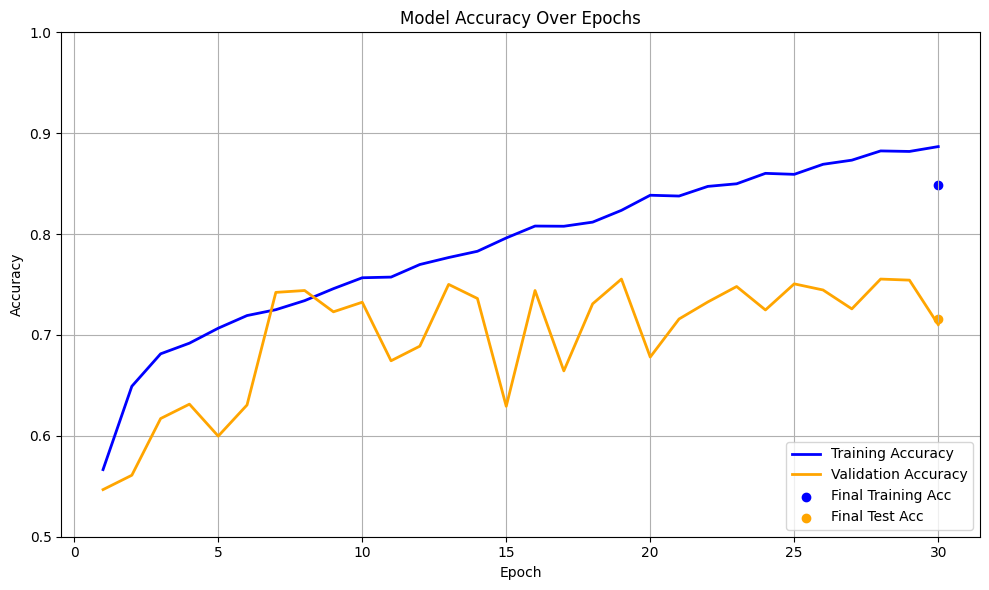

Final Training Accuracy: 84.82%
Final Test Accuracy: 71.55%


In [11]:
import matplotlib.pyplot as plt

# Original training and validation accuracy from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Final evaluation accuracy (not part of history, calculated separately)
final_train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
final_test_acc = model.evaluate(X_test, y_test, verbose=0)[1]

epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='blue', linewidth=2)
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', linewidth=2)

# Plot final points for reference
plt.scatter(len(epochs), final_train_acc, color='blue', marker='o', label='Final Training Acc')
plt.scatter(len(epochs), final_test_acc, color='orange', marker='o', label='Final Test Acc')

plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Optional: print final accuracies for reference
print(f"Final Training Accuracy: {final_train_acc*100:.2f}%")
print(f"Final Test Accuracy: {final_test_acc*100:.2f}%")


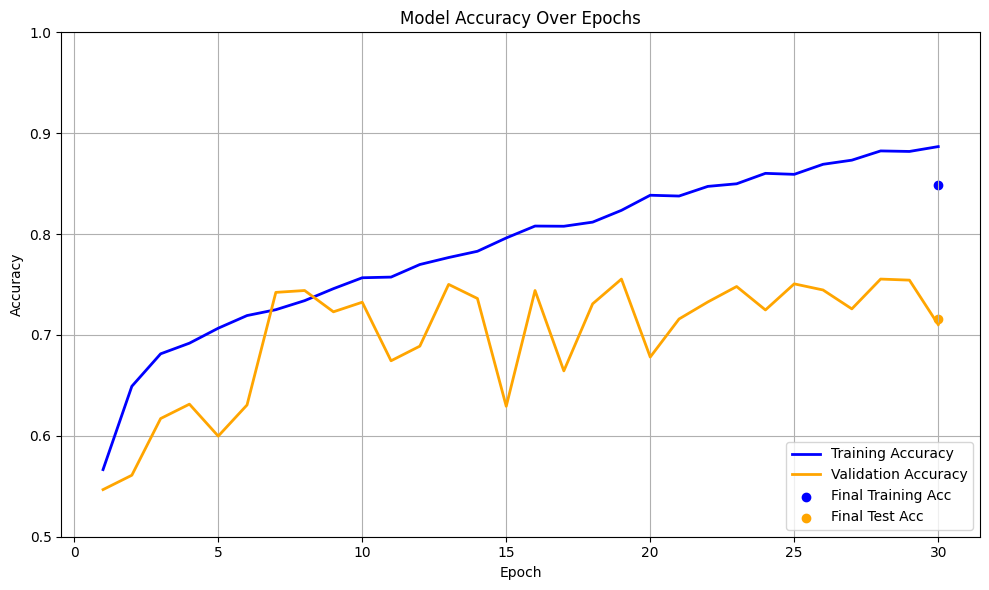

In [12]:
import matplotlib.pyplot as plt

# Accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Final evaluation values
final_train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
final_test_acc = model.evaluate(X_test, y_test, verbose=0)[1]

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='blue', linewidth=2)
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', linewidth=2)
plt.scatter(len(epochs), final_train_acc, color='blue', marker='o', label='Final Training Acc')
plt.scatter(len(epochs), final_test_acc, color='orange', marker='o', label='Final Test Acc')

plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


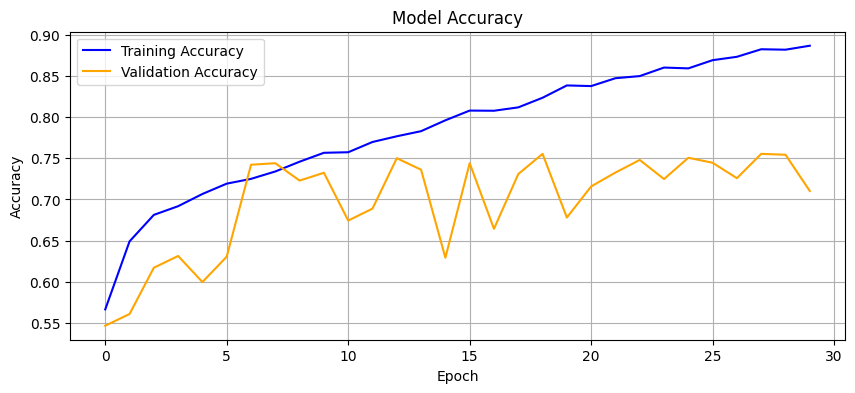

In [13]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


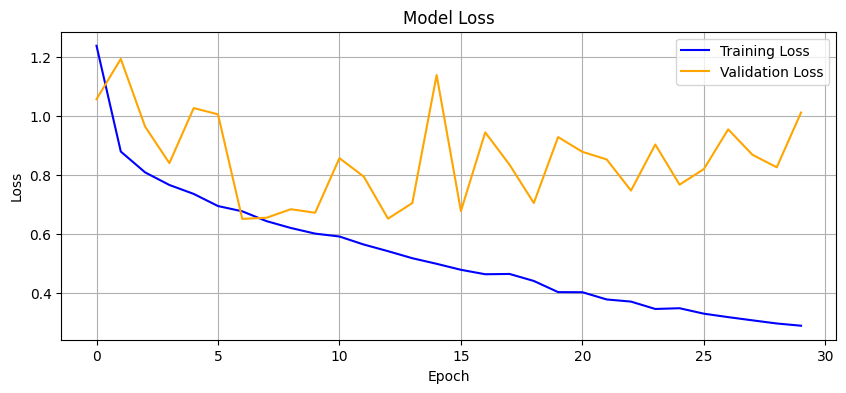

In [14]:
# Loss plot
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()



In [15]:
# Evaluate on training data
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")


593/593 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.8781 - loss: 0.3163
Training Accuracy: 84.82%


In [16]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")


593/593 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.8781 - loss: 0.3163
Final Training Accuracy: 84.82%
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7127 - loss: 0.9666
Final Test Accuracy: 71.55%


In [18]:
model.save("age_model.h5")
